In [317]:
import pyarrow.parquet as pq
import pandas as pd
import os
import googlemaps
import openrouteservice
import numpy as np
from tqdm import tqdm
import time
from geopy.distance import geodesic
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
GOOGLE_MAPS_API_KEY = os.environ['GOOGLE_MAPS_API_KEY']
gmaps = googlemaps.Client(key=GOOGLE_MAPS_API_KEY)

KeyError: 'GOOGLE_MAPS_API_KEY'

# Get intervention coordinates

In [138]:
file_configs = {
        'interventions3.parquet.gzip': {
            'event_types': [
                "P003 - Cardiac arrest",
                "P014 - Electrocution - electrification",
                "P019 - Unconscious - syncope",
                "P011 - Chest pain"
            ],
            'columns': {
                'longitude': "Longitude intervention",
                'latitude': "Latitude intervention",
                'event': "EventType Trip"
            }
        },
        'interventions1.parquet.gzip': {
            'event_types': [
                "P003 - Cardiac arrest",
                "P014 - Electrocution - electrification",
                "P019 - Unconscious - syncope",
                "P011 - Chest pain"
            ],
            'columns': {
                'longitude': "Longitude intervention",
                'latitude': "Latitude intervention",
                'event': "EventType Trip"
            }
        },
        'interventions_bxl2.parquet.gzip': {
            'event_types': [
                'HARTSTILSTAND - DOOD - OVERLEDEN',
                'PIJN OP DE BORST',
                'CARDIAAL PROBLEEM (ANDERE DAN PIJN AAN DE BORST)'
            ],
            'columns': {
                'longitude': "Longitude intervention",
                'latitude': "Latitude intervention",
                'event': "EventType and EventLevel"
            }
        },
        'interventions_bxl.parquet.gzip': {
            'event_types': [
                'P003 - Cardiac arrest',
                'P011 - Chest pain',
            ],
            'columns': {
                'longitude': "longitude_intervention",
                'latitude': "latitude_intervention",
                'event': "eventtype_trip"
            }
        }
    }

In [139]:
def format_coordinates(longitude, latitude):
    formatted_longitude = str(longitude)[:1] + '.' + str(longitude).replace('.', '')[1:]
    formatted_latitude = str(latitude)[:2] + '.' + str(latitude).replace('.', '')[2:]
    return formatted_longitude, formatted_latitude


def process_and_display_map_data(df, selected_file, show_cardiac_incidences):
    map_data = pd.DataFrame(columns=['lat', 'lon'])
    config = file_configs[selected_file]

    for index, row in df.iterrows():
        current_longitude = row[config['columns']['longitude']]
        current_latitude = row[config['columns']['latitude']]
        if pd.isnull(current_longitude) or pd.isnull(current_latitude):
            continue

        current_longitude, current_latitude = format_coordinates(current_longitude, current_latitude)

        if show_cardiac_incidences == 'Yes':
            is_interesting = any(event_type in row[config['columns']['event']] for event_type in config['event_types']) if row[config['columns']['event']] else False
            if is_interesting:
                map_data = pd.concat([map_data, pd.DataFrame({'lat': [float(current_latitude)], 'lon': [float(current_longitude)]})], ignore_index=True)
        else:
            map_data = pd.concat([map_data, pd.DataFrame({'lat': [float(current_latitude)], 'lon': [float(current_longitude)]})], ignore_index=True)
    
    return map_data

In [428]:
intervention1 = pq.ParquetFile(os.path.join('../data', 'interventions1.parquet.gzip')).read().to_pandas()
intervention2 = pq.ParquetFile(os.path.join('../data', 'interventions2.parquet.gzip')).read().to_pandas()
intervention3 = pq.ParquetFile(os.path.join('../data', 'interventions3.parquet.gzip')).read().to_pandas()
intervention4 = pq.ParquetFile(os.path.join('../data', 'interventions_bxl.parquet.gzip')).read().to_pandas()
intervention5 = pq.ParquetFile(os.path.join('../data', 'interventions_bxl2.parquet.gzip')).read().to_pandas()

In [429]:
for intervention_df in [intervention1, intervention2, intervention3, intervention4, intervention5]:
    intervention_df.columns = intervention_df.columns.str.lower().str.replace(' ', '_')

In [430]:
intervention4 = intervention4.rename(columns={'calculated_distance_destination_': 'calculated_distance_destination', 
                              'departure_time_t1reported': 'departure_time_(t1reported)',
                              'intervention_time_t1reported': 'intervention_time_(t1reported)'})

In [431]:
intervention5 = intervention5.rename(columns={'eventtype_and_eventlevel': 'eventtype_trip', 
                              'vector_type_nl': 'vector_type',
                              'abandon_reason_nl': 'abandon_reason'})

In [432]:
for intervention in [intervention1, intervention2, intervention3, intervention4]:
    intervention['eventlevel_trip'] = intervention['eventlevel_trip'].str.extract(r'N(\d{1})', expand=False)
    t3s = pd.to_datetime(intervention['t3'].str.replace('+00:00', '').str.strip(), format='%Y-%m-%d %H:%M:%S.%f')
    t6s = pd.to_datetime(intervention['t6'].str.replace('+00:00', '').str.strip(), format='%Y-%m-%d %H:%M:%S.%f')
    intervention['travel_time'] = (t6s - t3s).dt.total_seconds() / 60
intervention5['eventlevel_trip'] = intervention5['eventtype_trip'].str.extract(r'N0(\d{1})', expand=False)
intervention5['waiting_time'] = (pd.to_datetime(intervention5['t3'], format='%d%b%y:%H:%M:%S') - pd.to_datetime(intervention5['t0'], format='%d%b%y:%H:%M:%S')).dt.total_seconds() / 60
intervention5['travel_time'] = (pd.to_datetime(intervention5['t6'], format='%d%b%y:%H:%M:%S') - pd.to_datetime(intervention5['t3'], format='%d%b%y:%H:%M:%S')).dt.total_seconds() / 60

In [433]:
common_columns = list(set(intervention1.columns) & set(intervention4.columns) & set(intervention5.columns))
common_columns

['longitude_intervention',
 't6',
 'housenumber_permanence',
 'name_destination_hospital',
 'streetname_destination_hospital',
 'streetname_permanence',
 'number_of_transported_persons',
 'cityname_permanence',
 'vector_type',
 'housenumber_destination_hospital',
 'abandon_reason',
 'eventtype_trip',
 't1',
 'travel_time',
 'mission_id',
 't5',
 't2',
 't4',
 'eventlevel_trip',
 'latitude_intervention',
 'waiting_time',
 't0',
 'cityname_intervention',
 'latitude_permanence',
 't3',
 't7',
 'cityname_destination_hospital',
 'longitude_permanence']

In [434]:
interventions = pd.concat([intervention1[common_columns], intervention2[common_columns], intervention3[common_columns], intervention4[common_columns], intervention5[common_columns]], ignore_index=True)
interventions = interventions.loc[~(interventions['waiting_time'] < 0)]
arrests = interventions.loc[interventions['eventtype_trip'].str.contains("Cardiac arrest|Chest pain|HARTSTILSTAND|PIJN OP DE BORST|CARDIAAL PROBLEEM", na=False)]

In [435]:
arrests['survived'] = ~arrests['abandon_reason'].isin(['Overleden', 'Dood Ter Plaatse'])
arrests.shape

/var/folders/8t/4mtztt010752cj_569fwq_h00000gp/T/ipykernel_96762/2543895568.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(44814, 29)

/var/folders/8t/4mtztt010752cj_569fwq_h00000gp/T/ipykernel_96762/2095299914.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



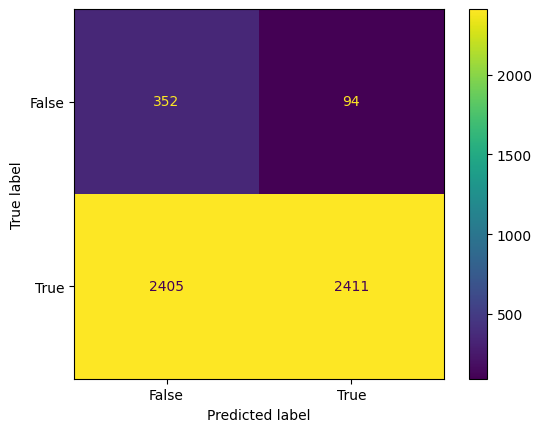

In [438]:
max_waiting_time = 1000
arrests_filtered = arrests.loc[arrests['waiting_time'] < max_waiting_time, ['waiting_time', 'eventlevel_trip', 'travel_time', 'survived']].dropna()

X = arrests_filtered[['waiting_time', 
'eventlevel_trip',
'travel_time',
]
]

# X = pd.get_dummies(X, columns=['eventlevel_trip'])
X['eventlevel_trip'] = X['eventlevel_trip'].astype(float)

y = arrests_filtered['survived']

# Split the data into training and testing sets
imputer = SimpleImputer()

# Preprocess the data by imputing missing values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Define the class weights
class_weights = {0: 15, 1: 1}

# Create the classifier with class weights
model = LogisticRegression(class_weight=class_weights)

# Fit the classifier to your data
model.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = model.predict(X_test)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, labels=model.classes_), display_labels=model.classes_)
disp.plot()

In [439]:
model.coef_

array([[0.04596438, 0.25619325, 0.03538206]])

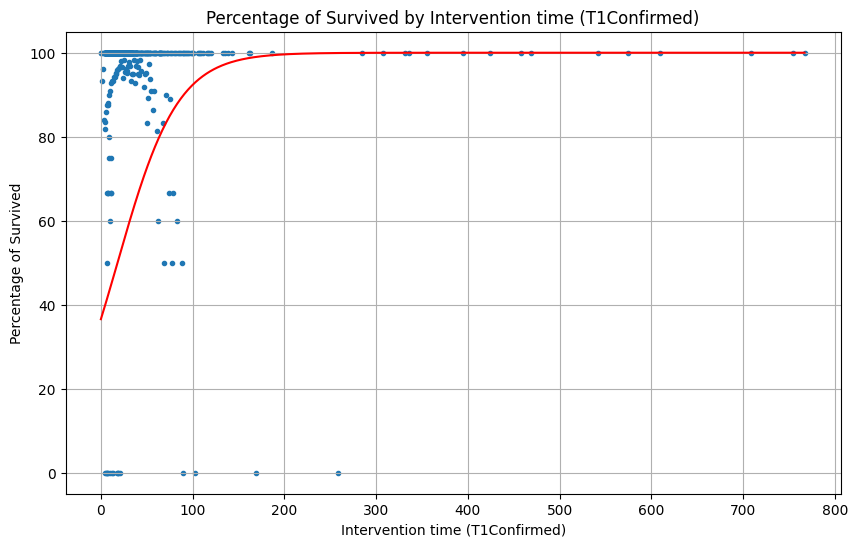

In [392]:
# Group the data by Intervention time (T1Confirmed) and calculate the percentage of Survived
survived_percentage = arrests_filtered.groupby('waiting_time')['survived'].mean() * 100
intervention_times = np.arange(0, arrests_filtered['waiting_time'].max(), 1)
predicted_percentages = model.predict_proba(intervention_times[:, np.newaxis])[:, 1] * 100


# Plot the percentage of Survived by Intervention time (T1Confirmed)
plt.figure(figsize=(10, 6))
plt.scatter(survived_percentage.index, survived_percentage.values, marker='.')
plt.plot(intervention_times, predicted_percentages, color='red', label='Logistic Regression')
plt.xlabel('Intervention time (T1Confirmed)')
plt.ylabel('Percentage of Survived')
plt.title('Percentage of Survived by Intervention time (T1Confirmed)')
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt


In [329]:
survived_percentage

waiting_time
-124.133333     100.000000
 0.000000       100.000000
 0.216667       100.000000
 1.000000        93.333333
 2.000000        96.153846
                   ...    
 709.000000     100.000000
 754.000000     100.000000
 768.000000     100.000000
 1223.000000    100.000000
 1397.000000    100.000000
Name: survived, Length: 838, dtype: float64

In [43]:
# Remove non-numeric columns from the dataframe
numeric_columns = arrests_with_short_intervention_time.select_dtypes(include=[np.number]).columns
df_numeric = arrests_with_short_intervention_time[numeric_columns]

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()
correlation_matrix

,Mission ID,PostalCode permanence,Latitude permanence,Longitude permanence,Latitude intervention,Longitude intervention,Intervention time (T1Reported),Intervention time (T1Confirmed),Waiting time,Intervention duration,Departure time (T1Reported),Departure time (T1Confirmed),Unavailable time,Calculated travelTime destinatio,Calculated Distance destination,Number of transported persons,Survived
Mission ID,1.000000,0.575174,0.018155,0.034865,0.017755,0.043463,0.061022,0.012527,0.057310,0.128469,-0.032409,0.019086,NaN,0.128625,0.112071,-0.013288,-0.055989
PostalCode permanence,0.575174,1.000000,0.084264,0.040294,0.016144,0.037482,0.097409,0.056789,0.078251,0.092349,0.017354,0.015725,NaN,0.097977,0.012048,-0.035267,-0.077289
Latitude permanence,0.018155,0.084264,1.000000,0.913057,0.774034,0.901578,0.031605,0.033936,0.014854,0.008694,0.014689,-0.000776,NaN,0.052661,-0.036052,-0.004998,-0.010552
Longitude permanence,0.034865,0.040294,0.913057,1.000000,0.916343,0.903703,0.025190,0.035171,0.015272,0.001493,0.035372,-0.004589,NaN,0.105791,-0.204979,0.004065,0.037126
Latitude intervention,0.017755,0.016144,0.774034,0.916343,1.000000,0.852948,-0.007087,0.001509,0.000859,0.015560,0.034346,0.000719,NaN,0.037959,-0.063628,-0.010255,0.012702
Longitude intervention,0.043463,0.037482,0.901578,0.903703,0.852948,1.000000,0.010305,0.015097,0.004033,0.003390,0.029857,-0.005437,NaN,0.101601,-0.204462,0.000931,0.011599
Intervention time (T1Reported),0.061022,0.097409,0.031605,0.025190,-0.007087,0.010305,1.000000,0.833845,0.703446,0.153066,0.214915,-0.025836,NaN,0.095838,0.122644,0.022401,0.149464
Intervention time (T1Confirmed),0.012527,0.056789,0.033936,0.035171,0.001509,0.015097,0.833845,1.000000,0.598132,0.106235,0.187432,0.010956,NaN,0.168084,0.178963,0.048802,0.155678
Waiting time,0.057310,0.078251,0.014854,0.015272,0.000859,0.004033,0.703446,0.598132,1.000000,0.222956,0.139204,0.007474,NaN,0.113988,0.154731,0.155381,0.130589
Intervention duration,0.128469,0.092349,0.008694,0.001493,0.015560,0.003390,0.153066,0.106235,0.222956,1.000000,-0.003213,0.005945,NaN,0.385136,0.384980,-0.034014,0.220402


In [5]:
coordinates1 = process_and_display_map_data(intervention1, 'interventions1.parquet.gzip', show_cardiac_incidences='Yes')
coordinates2 = process_and_display_map_data(intervention2, 'interventions1.parquet.gzip', show_cardiac_incidences='Yes')
coordinates3 = process_and_display_map_data(intervention3, 'interventions1.parquet.gzip', show_cardiac_incidences='Yes')

/var/folders/8t/4mtztt010752cj_569fwq_h00000gp/T/ipykernel_38548/3342450.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  map_data = pd.concat([map_data, pd.DataFrame({'lat': [float(current_latitude)], 'lon': [float(current_longitude)]})], ignore_index=True)
/var/folders/8t/4mtztt010752cj_569fwq_h00000gp/T/ipykernel_38548/3342450.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  map_data = pd.concat([map_data, pd.DataFrame({'lat': [float(current_latitude)], 'lon': [float(current_longitude

In [331]:
intervention_coordinates = pd.concat([coordinates1, coordinates2, coordinates3], ignore_index=True)
intervention_coordinates = intervention_coordinates.drop_duplicates()
intervention_coordinates['id'] = range(len(intervention_coordinates))
intervention_coordinates.to_csv('../transformed_data/intervention_coordinates.csv', index=False)

In [219]:
intervention_coordinates.shape

(32975, 3)

# Get AED coordinates

In [62]:
aed_locations = pq.ParquetFile(os.path.join('../data', 'aed_locations.parquet.gzip')).read().to_pandas()

In [ ]:
aed_addresses = []
for index, location in aed_locations.iterrows():
    number = '' if pd.isnull(location['number']) else location['number']
    postal_code = '' if pd.isnull(location['postal_code']) else int(location['postal_code'])
    address = f"{number} {location['address']}, {location['municipality']}, {location['province']}, Belgium {postal_code}"
    aed_addresses.append(address)

aed_locations['full_address'] = aed_addresses

In [97]:
aed_locations = aed_locations.drop_duplicates(subset=['full_address'])
aed_locations['id'] = range(len(aed_locations))
aed_locations

,id,type,address,number,postal_code,municipality,province,location,public,available,hours,full_address
0,0,None,Blvd. Fr. Roosevelt,24.0,7060.0,SOIGNIES,Hainaut,None,Y,None,None,"24.0 Blvd. Fr. Roosevelt, SOIGNIES, Hainaut, B..."
1,1,None,Ch. De Wégimont,76.0,4630.0,Ayeneux,Liège,None,None,None,None,"76.0 Ch. De Wégimont, Ayeneux, Liège, Belgium ..."
2,2,None,Place Saint - Lambert,NaN,4020.0,Liège,Liège,None,None,None,None,"Place Saint - Lambert, Liège, Liège, Belgium ..."
3,3,None,Rue du Doyard,NaN,4990.0,Lierneux,Liège,None,None,None,None,"Rue du Doyard, Lierneux, Liège, Belgium 4990"
4,4,None,Fond Saint Servais,NaN,4000.0,Liège,Liège,None,None,None,None,"Fond Saint Servais, Liège, Liège, Belgium 4000"
...,...,...,...,...,...,...,...,...,...,...,...,...
15221,13799,Appareil fixe-Vast apparaat,Nekkerspoel-Borcht,19.0,2800.0,Mechelen,Antwerpen,"Hoofdgebouw, 1ste verdieping, thv cafetaria",Oui-Ja,Non-Nee,maandag tot en met vrijdag van 8 tot 23 uur; w...,"19.0 Nekkerspoel-Borcht , Mechelen, Antwerpen,..."
15223,13800,Appareil fixe-Vast apparaat,Nieuwe Dreef,17.0,9160.0,Lokeren,Oost-Vlaanderen,Locatie : ingang poort hoofdgebouw,Oui-Ja,Oui-Ja,None,"17.0 Nieuwe Dreef , Lokeren, Oost-Vlaanderen, ..."
15224,13801,Appareil fixe-Vast apparaat,Panterschipstraat,207.0,9000.0,Gent,Oost-Vlaanderen,,Oui-Ja,Non-Nee,None,"207.0 Panterschipstraat , Gent, Oost-Vlaandere..."
15225,13802,Appareil fixe-Vast apparaat,Albert Leemansplein,20.0,1050.0,Bruxelles,Bruxelles-Brussel,,Oui-Ja,Non-Nee,None,"20.0 Albert Leemansplein, Bruxelles, Bruxelles..."


In [101]:
def get_lat_lon(address):
    # Geocode an address
    result = gmaps.geocode(address)

    # If result is not empty, extract latitude and longitude
    if result:
        location = result[0]['geometry']['location']
        return location['lat'], location['lng']
    else:
        return None, None

In [105]:
aed_lats = []
aed_lons = []

for address in aed_locations['full_address']:
    lat, lon = get_lat_lon(address)
    aed_lats.append(lat)
    aed_lons.append(lon)

In [108]:
aed_locations['lat'] = aed_lats
aed_locations['lon'] = aed_lons

In [332]:
aed_locations.to_csv('../transformed_data/aed_locations_full.csv', index=False)

# Get distance between intervention & AED coordinates

In [3]:
intervention_coordinates = pd.read_csv('../transformed_data/intervention_coordinates.csv')
aed_locations = pd.read_csv('../transformed_data/aed_locations_full.csv')

In [15]:
intervention_latlons = intervention_coordinates[['lat', 'lon']].values.tolist()
aed_latlons = aed_locations[['lat', 'lon']].values.tolist()

In [16]:
intervention_lonlats = intervention_coordinates[['lon', 'lat']].values.tolist()
aed_lonlats = aed_locations[['lon', 'lat']].values.tolist()

## Straight line distances

In [17]:
intervention_latlons_radians = np.radians(np.array(intervention_latlons))
aed_latlons_radians = np.radians(np.array(aed_latlons))

In [18]:
%time intervention_to_aed_distances_km = haversine_distances(intervention_latlons_radians, aed_latlons_radians) * 6371000/1000

CPU times: user 12.7 s, sys: 2.18 s, total: 14.8 s
Wall time: 15.6 s


In [13]:
np.save("../transformed_data/intervention_to_aed_distances_km.npy", intervention_to_aed_distances_km)

## Route distances

In [17]:
OPEN_ROUTE_SERVICE_API_KEY = os.environ['OPEN_ROUTE_SERVICE_API_KEY']
client = openrouteservice.Client(key=OPEN_ROUTE_SERVICE_API_KEY)  # Initialize client with your API key

In [23]:
%env OPEN_ROUTE_SERVICE_API_KEY=5b3ce3597851110001cf624805c793bf13394bf184fdf8716b14ab69

env: OPEN_ROUTE_SERVICE_API_KEY=5b3ce3597851110001cf624805c793bf13394bf184fdf8716b14ab69


In [24]:
client = openrouteservice.Client(key=OPEN_ROUTE_SERVICE_API_KEY)

In [25]:
def get_route_distances(source_coords, destination_coords):
    all_coords = source_coords + destination_coords
    routes = client.distance_matrix(source_coords + destination_coords, sources=list(range(len(source_coords))), destinations=list(range(len(source_coords), len(all_coords))), metrics=['distance'], units='km', validate=False)
    return np.array(routes['distances'])

In [7]:
# Split intervention_lonlats and aed_lonlats into chunks of 50 locations
intervention_chunks = [intervention_lonlats[i:i + 50] for i in range(0, len(intervention_lonlats), 50)]
aed_chunks = [aed_lonlats[i:i + 50] for i in range(0, len(aed_lonlats), 50)]

In [27]:
# Initialize an empty matrix to hold the distances
route_distances = np.full((len(intervention_lonlats), len(aed_lonlats)), np.nan)
elapsed_times = []

# Compute the distance matrix for each chunk
for i, intervention_chunk in enumerate(intervention_chunks):
    for j, aed_chunk in enumerate(aed_chunks):
        start_time = time.time()
        matrix = get_route_distances(intervention_chunk, aed_chunk)
        route_distances[i*50:(i+1)*50, j*50:(j+1)*50] = matrix
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Chunk {i+1} of {len(intervention_chunks)} and {j+1} of {len(aed_chunks)} completed in {elapsed_time} seconds")
        elapsed_times.append(elapsed_time)

ApiError: 403 ({'error': 'Access to this API has been disallowed'})

In [415]:
np.mean(elapsed_times) * (len(intervention_coordinates)/50 * len(aed_locations)/50) / 3600

46.49955369657295